In [1]:
import subprocess
import fnmatch
from pathlib import Path

import geowombat as gw
from geowombat.util import GeoDownloads
from geowombat.radiometry import BRDF, RadTransforms
from geowombat.data import rgbn

import xarray as xr
import dask.array as da

Using TensorFlow backend.


## Download data

In [11]:
gdl = GeoDownloads()

In [12]:
search_list = gdl.list_gcp('LC08/01/042/034/*_2016*_*_01_T1*/')

In [14]:
len(search_list)

384

In [15]:
search_list[:15]

['gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/:',
 'gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_ANG.txt',
 'gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_B1.TIF',
 'gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_B10.TIF',
 'gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_B11.TIF',
 'gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_B2.TIF',
 'gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_B3.TIF',
 'gs://gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20160121_2017

In [7]:
download_list = ['LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_ANG.txt',
                 'LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_MTL.txt',
                 'LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_B4.TIF',
                 'LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_B5.TIF',
                 'LC08/01/042/034/LC08_L1TP_042034_20160121_20170224_01_T1/LC08_L1TP_042034_20160121_20170224_01_T1_BQA.TIF']
    
file_info = gdl.download_gcp(download_list, outdir='/media/jcgr/data/imagery/temp/google', verbose=1)

06:20:28:INFO:130:web.download_gcp:  Downloading LC08_L1TP_042034_20160121_20170224_01_T1_BQA.TIF ...


In [8]:
file_info

[FileInfo(name='/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_ANG.txt', key='angle'),
 FileInfo(name='/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_MTL.txt', key='meta'),
 FileInfo(name='/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B4.TIF', key='band'),
 FileInfo(name='/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B5.TIF', key='band'),
 FileInfo(name='/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_BQA.TIF', key='band')]

## Get coefficients from metadata

In [2]:
rt = RadTransforms()

# meta = rt.get_coefficients(file_info[1].name)
meta = rt.get_coefficients('/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_MTL.txt')

In [3]:
meta

MetaCoeffs(sensor='l8', m_l={1: 0.012966, 2: 0.013277, 3: 0.012235, 4: 0.010317, 5: 0.0063136, 6: 0.0015701, 7: 0.00052922, 8: 0.011676, 9: 0.0024675, 10: 0.0003342, 11: 0.0003342}, a_l={1: -64.82956, 2: -66.38626, 3: -61.17437, 4: -51.58568, 5: -31.56786, 6: -7.85064, 7: -2.64609, 8: -58.38079, 9: -12.33744, 10: 0.1, 11: 0.1}, m_p={1: 2e-05, 2: 2e-05, 3: 2e-05, 4: 2e-05, 5: 2e-05, 6: 2e-05, 7: 2e-05, 8: 2e-05, 9: 2e-05}, a_p={1: -0.1, 2: -0.1, 3: -0.1, 4: -0.1, 5: -0.1, 6: -0.1, 7: -0.1, 8: -0.1, 9: -0.1})

## Check data

In [4]:
# with gw.open([file_info[2].name, file_info[3].name], 
#              band_names=['red', 'nir'],
#              stack_dim='band') as ds:
#     print(ds)
# #     ds.sel(band='nir').plot.imshow()

## Generate pixel angle files

In [5]:
# angle_info = gw.gen_pixel_angles(file_info[0].name, 
#                                  file_info[2].name, 
#                                  '/media/jcgr/data/imagery/temp/google/angles', 
#                                  meta.sensor, 
#                                  l57_angles_path='/home/jcgr/Documents/scripts/Python/git_repos/geowombat/bin/ESPA/landsat_angles', 
#                                  l8_angles_path='/home/jcgr/Documents/scripts/Python/git_repos/geowombat/bin/ESPA/l8_angles',
#                                  verbose=1)

In [11]:
# angle_info

AngleInfo(senaz='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_azimuth.tif', senze='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_zenith.tif', solaz='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_azimuth.tif', solze='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_zenith.tif')

In [6]:
# with gw.open(angle_info.senze) as ds:
#     ds.sel(band=1).plot.imshow(robust=True)

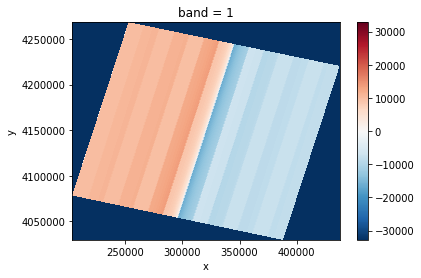

In [26]:
with gw.open(angle_info.senaz) as ds:
    ds.sel(band=1).plot.imshow(robust=True)

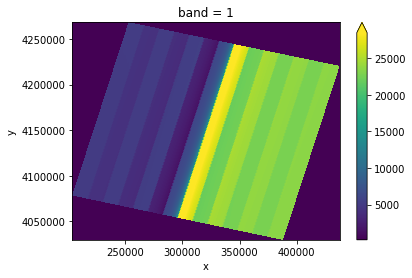

In [32]:
with gw.open(angle_info.solaz) as solaz:
    with gw.open(angle_info.senaz) as senaz:
        rel_azimuth_angle = xr.ufuncs.fabs(solaz - senaz - 180.0)
        rel_azimuth_angle.sel(band=1).plot.imshow(robust=True)

## Convert to surface reflectance

In [14]:
angle_info

AngleInfo(senaz='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_azimuth.tif', senze='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_zenith.tif', solaz='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_azimuth.tif', solze='/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_zenith.tif')

In [4]:
# with gw.open(angle_info.sze) as sze:
#     with gw.open(angle_info.vze) as vze:
#         with gw.open(angle_info.saa) as saa:
#             with gw.open(angle_info.vaa) as vaa:
#                 with gw.open([file_info[2].name, file_info[3].name], 
#                              band_names=['red', 'nir'],
#                              stack_dim='band') as dn:

with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_zenith.tif') as sze:
    with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_zenith.tif') as vze:
        with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_azimuth.tif') as saa:
            with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_azimuth.tif') as vaa:                
                
                with gw.open(['/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B4.TIF', 
                              '/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B5.TIF'], 
                             band_names=['red', 'nir'],
                             stack_dim='band') as dn:

                    # Convert DN to surface reflectance
                    dn_sr = rt.dn_to_sr(dn, sze, saa, vze, vaa, sensor=meta.sensor, meta=meta)
                    
                    dn_sr.gw.to_raster('/media/jcgr/data/imagery/temp/google/sr.tif', 
                                       readxsize=1024, 
                                       readysize=1024, 
                                       n_workers=4, 
                                       n_threads=4,
                                       overwrite=True)
                    
                    # BRDF normalization
                    #dn_sr_brdf = BRDF().norm_brdf(dn_sr, sze, saa, vze, vaa, sensor=meta.sensor, wavelengths=['red', 'nir'], nodata=0)

  0%|          | 0/64 [00:00<?, ?it/s]

RasterioIOError: Read or write failed. /media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B4.TIF, band 1: IReadBlock failed at X offset 2, Y offset 3: TIFFReadEncodedTile() failed.

In [5]:
dn_sr_brdf

<xarray.DataArray (band: 2, y: 7941, x: 7821)>
dask.array<transpose, shape=(2, 7941, 7821), dtype=float64, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 2.034e+05 2.034e+05 2.035e+05 ... 4.38e+05 4.38e+05
  * y        (y) float64 4.268e+06 4.268e+06 4.268e+06 ... 4.03e+06 4.03e+06
  * band     (band) object 'red' 'nir'
Attributes:
    transform:      (30.0, 0.0, 203385.0, 0.0, -30.0, 4268115.0)
    crs:            +init=epsg:32611
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point
    sensor:         l8
    nodata:         -32768
    method:         srem
    drange:         (0, 1)

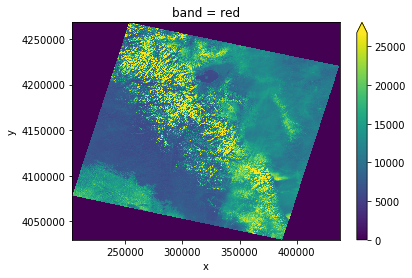

In [22]:
dn.sel(band='nir').plot.imshow(robust=True)

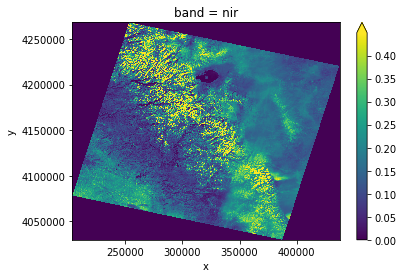

In [6]:
dn_sr.sel(band='nir').plot.imshow(robust=True)

In [6]:
dn_sr_brdf.sel(band='nir').plot.imshow(robust=True)

KeyboardInterrupt: 